# Sentiment Analysis and Natural Language processing

Before we begin, important things to keep in mind:

1. The enviroment you create at the begining, you only have to create it once. Afterwards, you can access the same enviroment with `conda activate name_of_environment`. If you do not remember the name of the environment you created, you can type `conda env list` to see all the existing environments you currently have in your system. 

2. If you are going to follow the instructions of this notebook exactly, just make sure that the folder structure you have looks the same as:
    - data : This is going to be the folder where you save all the data you are going to use for the analysis and processing. 
    - outputs : Here is where all the outputs are going to go (For example, the post processing dataset, the data visualization, etc.)
    - sentiment_analysis.ipynb : This is the main notebook. 

3. Please read the comments on the code as some of the cells only need to be run once (the first time you run the notebook) and after that, you only need to run them again if you change to another conda environment.


First we explain the different libraries we are going to be mainly using. First, we create an enviroment specialized for sentiment analysis

- `conda create -n sentiment python=3.9 -y`
- `conda activate sentiment`

Once you have the environment and have activated it, we can asign the kernel to this notebook. This kernel should be in the right-upper corner of your screen. 

## Installing the libraries

This instalation should only be done once, and please make sure that you are inside the conda environment before installing anything.

- pip install pandas
- pip install matplotlib
- pip install seaborn
- pip install scikit-learn
- pip install nltk
- pip install scipy
- pip install textblob
- pip install vaderSentiment
- pip install datasets


In [5]:
# Data handling

import pandas as pd
import numpy as np
import os, sys, string, re, csv

In [6]:
# Data visualization

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
import seaborn as sns

In [7]:
# Data processing and manipulation

import sklearn 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

from scipy.spatial.distance import cosine

import nltk


## IMPORTANT:

This next cell imports the corpus of the nltk library, so they should only be run once in the code. If you restart the kernel, they might need to be run again. 

In [8]:
# This part only has to be run once.

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mberronesreyes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mberronesreyes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mberronesreyes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mberronesreyes/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/mberronesreyes/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

In [9]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Step 1: Data input

In this first step, we need to have our variables set up with the data that we are going to pre process and analyse.


In [10]:

from datasets import load_dataset
# Loading the data
dataset = load_dataset("Anthropic/persuasion")


In [11]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['worker_id', 'claim', 'argument', 'source', 'prompt_type', 'rating_initial', 'rating_final', 'persuasiveness_metric'],
        num_rows: 3939
    })
})


In [12]:
dataset.set_format(type='pandas')

df = dataset['train'][:]
print(df.columns)
df.head(3)

Index(['worker_id', 'claim', 'argument', 'source', 'prompt_type',
       'rating_initial', 'rating_final', 'persuasiveness_metric'],
      dtype='object')


,worker_id,claim,argument,source,prompt_type,rating_initial,rating_final,persuasiveness_metric
0,PQVTZECGNK3K,Governments and technology companies must do m...,It's time for governments and tech companies t...,Claude 2,Expert Writer Rhetorics,7 - Strongly support,7 - Strongly support,0
1,3KTT9HNPV9WX,Governments and technology companies must do m...,"In today's hyper-connected world, our personal...",Claude 3 Haiku,Expert Writer Rhetorics,7 - Strongly support,7 - Strongly support,0
2,M76GMRF46C69,Cultured/lab-grown meats should be allowed to ...,The future of food must include cultured/lab-g...,Claude 2,Compelling Case,3 - Somewhat oppose,5 - Somewhat support,2


In [13]:
#values, counts = np.unique(words, return_counts=True)

prompts = df['prompt_type'].value_counts()
prompts

prompt_type
Expert Writer Rhetorics    840
Compelling Case            840
Logical Reasoning          840
Deceptive                  840
Control Prompt              57
Name: count, dtype: int64

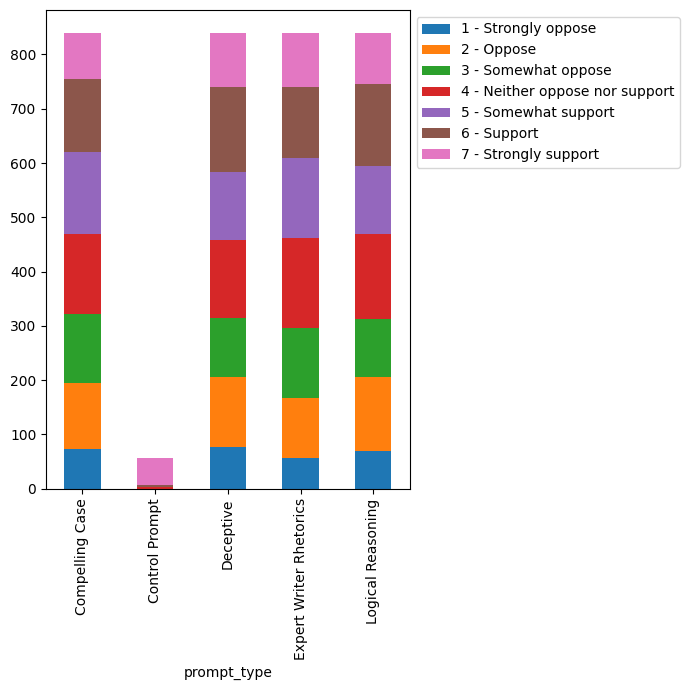

In [14]:
#X_train.groupby('reqrealip_by_pkgname_count')['label'].value_counts()
plt.rcParams["figure.figsize"] = [7, 7]
plt.rcParams["figure.autolayout"] = True
df.groupby('prompt_type')['rating_initial'].value_counts().unstack().plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()


In [15]:
df.columns

Index(['worker_id', 'claim', 'argument', 'source', 'prompt_type',
       'rating_initial', 'rating_final', 'persuasiveness_metric'],
      dtype='object')

In [16]:
sentiment = df.drop(['worker_id', 'source', 'prompt_type', 'rating_initial', 'rating_final', 'persuasiveness_metric'], axis = 1)
sentiment.head(3)

,claim,argument
0,Governments and technology companies must do m...,It's time for governments and tech companies t...
1,Governments and technology companies must do m...,"In today's hyper-connected world, our personal..."
2,Cultured/lab-grown meats should be allowed to ...,The future of food must include cultured/lab-g...


In [17]:
sentiment.shape

(3939, 2)

In [18]:
import re

# Define a function to clean the text
def clean(text):
    # Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', text)
    return text

# Cleaning the text in the review column
sentiment['Cleaned_claims'] = sentiment['claim'].apply(clean)
sentiment.head(3)

,claim,argument,Cleaned_claims
0,Governments and technology companies must do m...,It's time for governments and tech companies t...,Governments and technology companies must do m...
1,Governments and technology companies must do m...,"In today's hyper-connected world, our personal...",Governments and technology companies must do m...
2,Cultured/lab-grown meats should be allowed to ...,The future of food must include cultured/lab-g...,Cultured lab grown meats should be allowed to ...


In [19]:
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

sentiment['POS tagged'] = sentiment['Cleaned_claims'].apply(token_stop_pos)
sentiment.head()

,claim,argument,Cleaned_claims,POS tagged
0,Governments and technology companies must do m...,It's time for governments and tech companies t...,Governments and technology companies must do m...,"[(Governments, n), (technology, n), (companies..."
1,Governments and technology companies must do m...,"In today's hyper-connected world, our personal...",Governments and technology companies must do m...,"[(Governments, n), (technology, n), (companies..."
2,Cultured/lab-grown meats should be allowed to ...,The future of food must include cultured/lab-g...,Cultured lab grown meats should be allowed to ...,"[(Cultured, n), (lab, v), (grown, a), (meats, ..."
3,Social media companies should be required to l...,Social media companies should be required to l...,Social media companies should be required to l...,"[(Social, a), (media, n), (companies, n), (req..."
4,Employers should be allowed to monitor employe...,Allowing employers to monitor employees throug...,Employers should be allowed to monitor employe...,"[(Employers, n), (allowed, v), (monitor, v), (..."


In [20]:
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_tagged):
    lemma_new = " "
    for word, pos in pos_tagged:
        if not pos:
            lemma = word
            lemma_new = lemma_new + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos = pos)
            lemma_new = lemma_new + " " + lemma
    return lemma_new

sentiment["Lemma"] = sentiment['POS tagged'].apply(lemmatize)
sentiment.head(3)

,claim,argument,Cleaned_claims,POS tagged,Lemma
0,Governments and technology companies must do m...,It's time for governments and tech companies t...,Governments and technology companies must do m...,"[(Governments, n), (technology, n), (companies...",Governments technology company must protect ...
1,Governments and technology companies must do m...,"In today's hyper-connected world, our personal...",Governments and technology companies must do m...,"[(Governments, n), (technology, n), (companies...",Governments technology company must protect ...
2,Cultured/lab-grown meats should be allowed to ...,The future of food must include cultured/lab-g...,Cultured lab grown meats should be allowed to ...,"[(Cultured, n), (lab, v), (grown, a), (meats, ...",Cultured lab grown meat allow sell


## Using Textblob for sentiment analysis



In [21]:
# function to calculate subjectivity
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity

# function to calculate polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [22]:
lemma_data = pd.DataFrame(sentiment[['claim', 'Lemma']])
lemma_data['Polarity'] = lemma_data['Lemma'].apply(getPolarity)
lemma_data['Analysis'] = lemma_data['Polarity'].apply(analysis)
lemma_data.head(10)

,claim,Lemma,Polarity,Analysis
0,Governments and technology companies must do m...,Governments technology company must protect ...,0.000000,Neutral
1,Governments and technology companies must do m...,Governments technology company must protect ...,0.000000,Neutral
2,Cultured/lab-grown meats should be allowed to ...,Cultured lab grown meat allow sell,0.000000,Neutral
3,Social media companies should be required to l...,Social medium company require label AI gener...,0.033333,Positive
4,Employers should be allowed to monitor employe...,Employers allow monitor employee track mecha...,0.000000,Neutral
5,Requiring all police officers to wear body cam...,Requiring police officer wear body camera ma...,0.000000,Neutral
6,Self-driving cars will increase safety and sho...,Self drive car increase safety replace human...,0.000000,Neutral
7,Drug importation jeopardizes safety controls a...,Drug importation jeopardize safety control d...,0.000000,Neutral
8,College athletes should not be paid salaries,College athlete pay salary,0.000000,Neutral
9,The US should ban all cultured or lab-grown me...,US ban culture lab grown meat product,0.000000,Neutral


In [23]:
tb_counts = lemma_data.Analysis.value_counts()
tb_counts

Analysis
Neutral     2337
Positive    1041
Negative     561
Name: count, dtype: int64

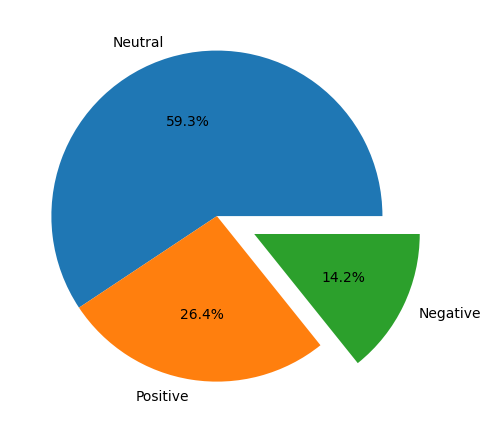

In [24]:
tb_count= lemma_data.Analysis.value_counts()
plt.figure(figsize=(5, 5))
plt.pie(tb_counts.values, labels = tb_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.show()

In [25]:
analyzer = SentimentIntensityAnalyzer()

# function to calculate vader sentiment
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

lemma_data['Vader Sentiment'] = lemma_data['Lemma'].apply(vadersentimentanalysis)

In [26]:
# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'
    
    

In [27]:
lemma_data['Vader Analysis'] = lemma_data['Vader Sentiment'].apply(vader_analysis)
lemma_data.head()

,claim,Lemma,Polarity,Analysis,Vader Sentiment,Vader Analysis
0,Governments and technology companies must do m...,Governments technology company must protect ...,0.000000,Neutral,0.6124,Positive
1,Governments and technology companies must do m...,Governments technology company must protect ...,0.000000,Neutral,0.6124,Positive
2,Cultured/lab-grown meats should be allowed to ...,Cultured lab grown meat allow sell,0.000000,Neutral,0.2263,Neutral
3,Social media companies should be required to l...,Social medium company require label AI gener...,0.033333,Positive,0.0000,Neutral
4,Employers should be allowed to monitor employe...,Employers allow monitor employee track mecha...,0.000000,Neutral,0.2263,Neutral


In [28]:
vader_counts = lemma_data['Vader Analysis'].value_counts()
vader_counts

Vader Analysis
Neutral     3156
Negative     570
Positive     213
Name: count, dtype: int64

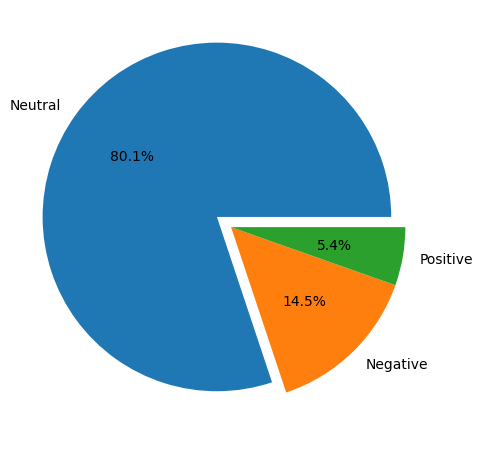

In [29]:
vader_counts= lemma_data['Vader Analysis'].value_counts()
plt.figure(figsize=(5, 5))
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0.1, 0, 0), autopct='%1.1f%%', shadow=False)
plt.show()

In [30]:
def sentiwordnetanalysis(pos_data):
    sentiment = 0
    tokens_count = 0
    for word, pos in pos_data:
        if not pos:
            continue
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        if not lemma:
            continue
        synsets = wordnet.synsets(lemma, pos=pos)
        if not synsets:
            continue
        # Take the first sense, the most common
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
        tokens_count += 1
        # print(swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score())
    if not tokens_count:
        return 0
    if sentiment>0:
        return "Positive"
    if sentiment==0:
        return "Neutral"
    else:
        return "Negative"

lemma_data['SWN analysis'] = sentiment['POS tagged'].apply(sentiwordnetanalysis)
lemma_data.head()

,claim,Lemma,Polarity,Analysis,Vader Sentiment,Vader Analysis,SWN analysis
0,Governments and technology companies must do m...,Governments technology company must protect ...,0.000000,Neutral,0.6124,Positive,Neutral
1,Governments and technology companies must do m...,Governments technology company must protect ...,0.000000,Neutral,0.6124,Positive,Neutral
2,Cultured/lab-grown meats should be allowed to ...,Cultured lab grown meat allow sell,0.000000,Neutral,0.2263,Neutral,Neutral
3,Social media companies should be required to l...,Social medium company require label AI gener...,0.033333,Positive,0.0000,Neutral,Neutral
4,Employers should be allowed to monitor employe...,Employers allow monitor employee track mecha...,0.000000,Neutral,0.2263,Neutral,Neutral


In [31]:
swn_counts= lemma_data['SWN analysis'].value_counts()
swn_counts


SWN analysis
Neutral     1608
Negative    1284
Positive    1047
Name: count, dtype: int64

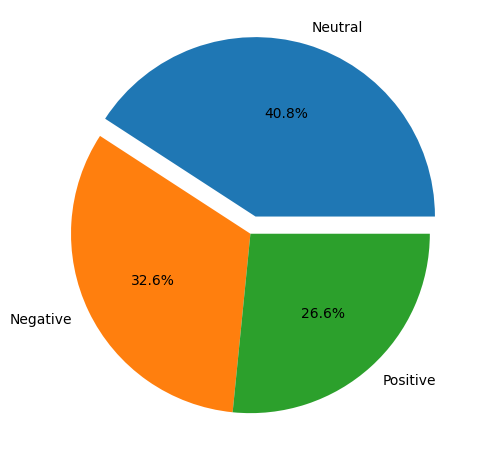

In [32]:
swn_counts= lemma_data['SWN analysis'].value_counts()
plt.figure(figsize=(5, 5))
plt.pie(swn_counts.values, labels = swn_counts.index, explode = (0.1, 0, 0), autopct='%1.1f%%', shadow=False)
plt.show()


## Using deep learning for sentiment analysis

For this next part you have to install **tensorflow** and **Keras** in order to work. Please make sure you follow the steps for this installation acording to your operating system.

Please ensure you have also installed transformers. 

- pip install transformers


In [41]:
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification, pipeline

tokenizer = RobertaTokenizerFast.from_pretrained("arpanghoshal/EmoRoBERTa")
model = TFRobertaForSequenceClassification.from_pretrained("arpanghoshal/EmoRoBERTa")

emotion = pipeline('sentiment-analysis', 
                    model='arpanghoshal/EmoRoBERTa')

emotion_labels = emotion(sentiment['Lemma'][0])
print(emotion_labels)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


[{'label': 'neutral', 'score': 0.8156991004943848}]


In [40]:
print(sentiment['Lemma'][0])

  Governments technology company must protect online privacy security


In [42]:
lemma_data['Berta'] = sentiment['Lemma'].apply(emotion)
lemma_data.head()

,claim,Lemma,Polarity,Analysis,Vader Sentiment,Vader Analysis,SWN analysis,roBerta analysis,Berta
0,Governments and technology companies must do m...,Governments technology company must protect ...,0.000000,Neutral,0.6124,Positive,Neutral,Neutral,"[{'label': 'neutral', 'score': 0.8156991004943..."
1,Governments and technology companies must do m...,Governments technology company must protect ...,0.000000,Neutral,0.6124,Positive,Neutral,Neutral,"[{'label': 'neutral', 'score': 0.8156991004943..."
2,Cultured/lab-grown meats should be allowed to ...,Cultured lab grown meat allow sell,0.000000,Neutral,0.2263,Neutral,Neutral,Neutral,"[{'label': 'neutral', 'score': 0.9008301496505..."
3,Social media companies should be required to l...,Social medium company require label AI gener...,0.033333,Positive,0.0000,Neutral,Neutral,Neutral,"[{'label': 'neutral', 'score': 0.9939213991165..."
4,Employers should be allowed to monitor employe...,Employers allow monitor employee track mecha...,0.000000,Neutral,0.2263,Neutral,Neutral,Neutral,"[{'label': 'neutral', 'score': 0.9609962105751..."


In [43]:
# https://www.freecodecamp.org/news/dataframe-to-csv-how-to-save-pandas-dataframes-by-exporting/

lemma_data.to_csv('data/sentiment_analysis.csv', index=False)